In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="7k9RzlTrav0kMFIzfIgu")
project = rf.workspace().project("chessv1-5ew7x")
chess_piece_model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [2]:
rf = Roboflow(api_key="7k9RzlTrav0kMFIzfIgu")
project = rf.workspace().project("chessboard-segmentation")
chess_board_model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [3]:
img_path = "Chess-Pieces-24/test/images/d7887071e972604ddf5940d8eb2702e7_jpg.rf.5f20fe9a6c746d488d6d0478828478cb.jpg"

In [4]:
# infer on a local image
res = chess_board_model.predict(img_path, confidence=80)
pred = res.json()['predictions']
res.save("board.jpg")
points = pred[0]["points"]

In [5]:
import numpy as np
points = np.array([np.array([p['x'], p['y']]) for p in points])

In [6]:
F = points[0]
dis = np.linalg.norm(points-F, axis=1)
A = points[np.argmax(dis)]

dis = np.linalg.norm(points-A, axis=1)
B = points[np.argmax(dis)]

In [7]:
def distance(p1, p2, p3):
    return np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)

In [8]:
def getArea(points):
    res = 0
    n = len(points)
    for i in range(n):
        res += (points[(i+1)%n][0]-points[i][0])*(points[(i+1)%n][1]+points[i][1])/2
    return abs(res)

In [9]:
polygon_area = getArea(points)
polygon_area

98010.28250000002

In [10]:
C = points[np.argmax(distance(A, B, points))]
D = points[np.argmin(distance(A, B, points))]

In [11]:
print(getArea([A, C, B, D]))
print(getArea([A, B, C, D]))

96638.00249999999
13953.907499999972


In [12]:
A, B, C, D

(array([372.45, 362.7 ]),
 array([63.7, 35.1]),
 array([314.6,  35.1]),
 array([ 37.05, 366.6 ]))

In [13]:
err_rate = abs(1-getArea([A, C, B, D])/polygon_area)
if err_rate > 0.1:
    C = points[0]
    D = points[1]
    for i, p1 in enumerate(points):
        for j, p2 in enumerate(points[:i]):
            if (getArea([A, B, p1, p2]) > getArea([A, B, C, D])):
                C = p1
                D = p2
            if (getArea([A, B, p2, p1]) > getArea([A, B, C, D])):
                C = p2
                D = p1
else:
    A, B, C, D = A, C, B, D

In [14]:
pts = np.array([A, B, C, D])
A = pts[np.argmin(np.sum(pts, axis=1))]
C = pts[np.argmax(np.sum(pts, axis=1))]

for p in pts:
    if p[0]-p[1] > B[0]-B[1]:
        B = p
    if p[0]-p[1] < D[0]-D[1]:
        D = p
A, B, C, D

(array([63.7, 35.1]),
 array([314.6,  35.1]),
 array([372.45, 362.7 ]),
 array([ 37.05, 366.6 ]))

In [15]:
import cv2
img = cv2.imread(img_path)
w, h = 640, 640
# offset = (polygon_area ** (1/2))/16
offset = 64

# pts1 = np.float32([A-offset, [B[0]+offset, B[1]-offset], C+offset, [D[0]-offset, D[1]+offset]])
pts1 = np.float32([A, B, C, D])
pts2 = np.float32([[offset, offset], [w-offset, offset], [w-offset, h-offset], [offset, h-offset]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
img = cv2.warpPerspective(img, matrix, (w, h))

# x1, y1 = D
# x2, y2 = A
# x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
# cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
cv2.imwrite("board_pred.jpg", img) 

True

In [16]:
a, b, c, d = cv2.perspectiveTransform(np.float32([[A, B, C, D]]), matrix)[0]
for i in range(0, 9):
    p1 = a + (b - a)*i/8
    p2 = d + (c - d)*i/8
    x1, y1 = p1
    x2, y2 = p2
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
    
for i in range(0, 9):
    p1 = a + (d - a)*i/8
    p2 = b + (c - b)*i/8
    x1, y1 = p1
    x2, y2 = p2
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
cv2.imwrite("test.jpg", img) 

True

In [17]:
# infer on a local image
res = chess_piece_model.predict("board_pred.jpg", confidence=50, overlap=30)
preds = res.json()['predictions']
print(len(pred))
print(pred)
res.save("piece.jpg")

# visualize your prediction
# model.predict("G000_IMG000.jpg", confidence=50, overlap=30).save("G000_IMG000_pred.jpg")

# infer on an image hosted elsewhere
# print(model.predict("G000_IMG000.jpg", hosted=True, confidence=40, overlap=30).json())

1
[{'x': 207.0, 'y': 201.0, 'width': 340.0, 'height': 332.0, 'confidence': 0.9565247297286987, 'class': '0', 'points': [{'x': 63.7, 'y': 35.1}, {'x': 63.7, 'y': 37.050000000000004}, {'x': 63.050000000000004, 'y': 37.7}, {'x': 63.050000000000004, 'y': 41.6}, {'x': 62.400000000000006, 'y': 42.25}, {'x': 62.400000000000006, 'y': 51.35}, {'x': 61.75, 'y': 52.0}, {'x': 61.75, 'y': 66.3}, {'x': 61.1, 'y': 66.95}, {'x': 61.1, 'y': 70.2}, {'x': 60.45, 'y': 70.85000000000001}, {'x': 60.45, 'y': 74.10000000000001}, {'x': 59.800000000000004, 'y': 74.75}, {'x': 59.800000000000004, 'y': 81.25}, {'x': 59.15, 'y': 81.9}, {'x': 59.15, 'y': 87.75}, {'x': 58.5, 'y': 88.4}, {'x': 58.5, 'y': 91.0}, {'x': 57.85, 'y': 91.65}, {'x': 57.85, 'y': 94.25}, {'x': 57.2, 'y': 94.9}, {'x': 57.2, 'y': 98.8}, {'x': 56.550000000000004, 'y': 99.45}, {'x': 56.550000000000004, 'y': 120.9}, {'x': 55.9, 'y': 121.55}, {'x': 55.9, 'y': 125.45}, {'x': 55.25, 'y': 126.10000000000001}, {'x': 55.25, 'y': 132.6}, {'x': 54.6, 'y': 

In [18]:
def isInside(pt, rect):
    return (pt[0] >= rect[0]) and (pt[0] <= rect[2]) and (pt[1] >= rect[1]) and (pt[1] <= rect[3]) 

def getCenter(i, j):
    o = a + (b - a)/16.0 + (d - a)/16.0
    p = o + (b - a)*i/8.0 + (d - a)*j/8.0
    return p
    
def isInCell(i, j, rect):
    return isInside(getCenter(i,j), rect)

In [19]:
pred = preds[0]
x = pred["x"]
y = pred["y"]
w = int(pred["width"])
h = int(pred["height"])
x = int(x - w/2)
y = int(y - h/2)
conf = pred["confidence"]
type = pred["class"]
print(x, y, h, w, conf, type)
cv2.line(img, (x, y), (x+w, y+h), (0, 255, 255), thickness=2)
cv2.circle(img, (x, y), 2, (255, 255, 0), thickness=2)
cv2.imwrite("1_piece.jpg", img)

51 156 157 68 0.9176697134971619 8


True

In [20]:
a, b, c, d

(array([64., 64.], dtype=float32),
 array([576.,  64.], dtype=float32),
 array([576., 576.], dtype=float32),
 array([ 64., 576.], dtype=float32))

In [21]:
board = np.zeros(shape=(8,8,2))
for pred in preds:
    x = pred["x"]
    y = pred["y"]
    w = pred["width"]
    h = pred["height"]
    x = x - w/2
    y = y - h/2
    conf = pred["confidence"]
    type = pred["class"]
    tmp = None
    for i in range(8):
        for j in range(8):
            if (type == "4" and i == 4 and j == 6):
                print(getCenter(i, j), [x, y, x+w, y+h], isInCell(i, j, [x, y, x+w, y+h]))
            if isInCell(i, j, [x, y, x+w, y+h]):
                if tmp is None or tmp[1] < j:
                    tmp = [i, j]
    
    if tmp is not None and board[tmp[0]][tmp[1]][1] < conf:
        board[tmp[0]][tmp[1]] = type, conf

[352. 480.] [339.0, 430.0, 380.0, 501.0] True
[352. 480.] [462.0, 222.0, 509.0, 307.0] False
[352. 480.] [390.0, 353.0, 436.0, 430.0] False


In [23]:
pieceList = {
    "1": "b",
    "2": "k",
    "3": "n",
    "4": "p",
    "5": "q",
    "6": "r",
    "7": "B",
    "8": "K",
    "9": "N",
    "10": "P",
    "11": "Q",
    "12": "R",
}
    

In [24]:
for j in range(8):
    for i in range(8):
        print(board[i][j][1], end=" ")
    print()
board = np.int32(board)
for j in range(8):
    for i in range(8):
        print(board[i][j][0], end=" ")
    print()

0.0 0.8924262523651123 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.8795132040977478 0.8834444284439087 0.8746273517608643 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.9176697134971619 0.8591285943984985 0.0 0.868615448474884 0.0 0.0 0.8665637969970703 0.9037107229232788 
0.0 0.0 0.0 0.868095874786377 0.0 0.0 0.0 0.0 
0.0 0.0 0.8657084703445435 0.0 0.0 0.8648034334182739 0.0 0.0 
0.0 0.8567072749137878 0.0 0.8781675100326538 0.8668084144592285 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0 6 0 0 0 0 0 0 
0 10 11 12 0 0 0 0 
0 0 0 0 0 0 0 0 
8 10 0 1 0 0 4 2 
0 0 0 7 0 0 0 0 
0 0 10 0 0 4 0 0 
0 3 0 9 4 0 0 0 
0 0 0 0 0 0 0 0 


In [25]:
fen = ""
for j in range(8):
    cnt = 0
    for i in range(8):
        if (board[i][j][0] == 0):
            cnt += 1
        else:
            if cnt != 0:
                fen += str(cnt)
                cnt = 0
            fen += pieceList[str(board[i][j][0])]
    if cnt != 0:
        fen += str(cnt)
    fen += "/"
fen = fen[:-1]

In [26]:
import chess
visual_board = chess.Board(fen)

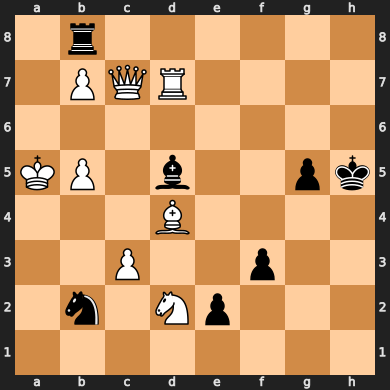

In [27]:
visual_board